# 多量子比特系统可解释量子机器学习实验
## 实验概述
本实验旨在将单量子比特系统的可解释量子机器学习方法扩展到多量子比特系统，验证物理信息神经网络(PINN)在更复杂量子系统中的有效性，并研究纠缠等多量子比特特性的可解释性表示。
### 实验目标
1. 扩展物理信息神经网络架构以适应多量子比特系统
2. 实现多量子比特量子态的有效重构
3. 保持并增强量子态重构的可解释性
4. 研究纠缠等多量子比特特性的量化表示

In [21]:
# 导入必要的库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import sqrtm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子确保可重复性
np.random.seed(42)
torch.manual_seed(42)

# 设置matplotlib样式
plt.style.use('default')
sns.set_palette("husl")

print("环境配置完成！")

环境配置完成！


In [22]:
class MultiQubitQuantumTools:
    """多量子比特系统工具类"""
    
    @staticmethod
    def random_pure_state(n_qubits):
        """生成随机纯态"""
        dim = 2**n_qubits
        state = np.random.randn(dim) + 1j * np.random.randn(dim)
        return state / np.linalg.norm(state)
    
    @staticmethod
    def random_mixed_state(n_qubits, purity=0.8):
        """生成随机混合态"""
        dim = 2**n_qubits
        # 生成随机纯态
        psi = MultiQubitQuantumTools.random_pure_state(n_qubits)
        rho = np.outer(psi, psi.conj())
        
        # 添加噪声以创建混合态
        identity = np.eye(dim, dtype=complex)
        rho_mixed = purity * rho + (1 - purity) * identity / dim
        return rho_mixed / np.trace(rho_mixed)
    
    @staticmethod
    def GHZ_state(n_qubits):
        """生成GHZ态"""
        dim = 2**n_qubits
        state = np.zeros(dim, dtype=complex)
        state[0] = 1/np.sqrt(2)
        state[-1] = 1/np.sqrt(2)
        return np.outer(state, state.conj())
    
    @staticmethod
    def W_state(n_qubits):
        """生成W态（适用于2和3量子比特）"""
        if n_qubits == 2:
            # 对于2量子比特，使用Bell态之一作为类似W态
            state = np.array([0, 1/np.sqrt(2), 1/np.sqrt(2), 0], dtype=complex)
        elif n_qubits == 3:
            # 标准3量子比特W态
            state = np.array([0, 1/np.sqrt(3), 1/np.sqrt(3), 0, 1/np.sqrt(3), 0, 0, 0], dtype=complex)
        else:
            # 对于更高量子比特数，生成一个简单的W-like态
            state = np.zeros(2**n_qubits, dtype=complex)
            for i in range(n_qubits):
                idx = 2**i  # 二进制表示中只有一个1的位置
                state[idx] = 1/np.sqrt(n_qubits)
        return np.outer(state, state.conj())
    
    @staticmethod
    def pauli_operators():
        """返回单量子比特Pauli算符"""
        I = np.array([[1, 0], [0, 1]], dtype=complex)
        X = np.array([[0, 1], [1, 0]], dtype=complex)
        Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
        Z = np.array([[1, 0], [0, -1]], dtype=complex)
        return [I, X, Y, Z]
    
    @staticmethod
    def multiqubit_pauli_matrices(n_qubits):
        """生成多量子比特Pauli测量算符"""
        paulis = MultiQubitQuantumTools.pauli_operators()
        
        if n_qubits == 1:
            return paulis
        
        # 多量子比特情况：张量积
        multi_paulis = []
        for ops in np.ndindex((4,) * n_qubits):
            op = paulis[ops[0]]
            for i in range(1, n_qubits):
                op = np.kron(op, paulis[ops[i]])
            multi_paulis.append(op)
        
        return multi_paulis
    
    @staticmethod
    def simulate_measurements(rho, n_measurements=1000, noise_level=0.01):
        """模拟具有shot noise和系统噪声的量子测量过程"""
        n_qubits = int(np.log2(rho.shape[0]))
        paulis = MultiQubitQuantumTools.multiqubit_pauli_matrices(n_qubits)
        
        frequencies = []
        for pauli in paulis:
            # 计算期望值并转为测量概率
            expectation = np.real(np.trace(rho @ pauli))
            prob = np.clip((expectation + 1) / 2, 0, 1)
            
            # Shot noise：对每个测量设置随机的shot数
            jitter = max(1, int(n_measurements * 0.2))
            shots = max(10, int(n_measurements + np.random.randint(-jitter, jitter + 1)))
            shot_freq = np.random.binomial(shots, prob) / shots
            
            # 系统噪声：附加高斯噪声
            noisy_freq = shot_freq + np.random.normal(0, noise_level)
            noisy_freq = np.clip(noisy_freq, 0, 1)
            frequencies.append(noisy_freq)
        
        return np.array(frequencies)
    
    @staticmethod
    def fidelity(rho1, rho2):
        """计算量子态保真度"""
        # 确保输入是numpy数组
        if hasattr(rho1, 'cpu'):
            rho1 = rho1.cpu().numpy()
        if hasattr(rho2, 'cpu'):
            rho2 = rho2.cpu().numpy()
        
        sqrt_rho1 = sqrtm(rho1)
        fidelity_matrix = sqrtm(sqrt_rho1 @ rho2 @ sqrt_rho1)
        return np.real(np.trace(fidelity_matrix))**2
    
    @staticmethod
    def constraint_violation(rho):
        """计算物理约束违反程度"""
        # 确保输入是numpy数组
        if hasattr(rho, 'cpu'):
            rho = rho.cpu().numpy()
        
        # 厄米性违反
        hermiticity = np.linalg.norm(rho - rho.conj().T)
        
        # 迹归一化违反
        trace_violation = abs(np.trace(rho) - 1)
        
        # 正定性违反 (最小特征值)
        eigenvals = np.linalg.eigvals(rho)
        positivity_violation = max(0, -np.real(eigenvals).min())
        
        return hermiticity + trace_violation + positivity_violation
    
    @staticmethod
    def cholesky_to_density_matrix(alpha, n_qubits):
        """从Cholesky参数构造密度矩阵"""
        dim = 2**n_qubits
        n_params = dim * (dim + 1) // 2
        
        # 确保alpha是numpy数组
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        
        if alpha.size < 2 * n_params:
            alpha = np.pad(alpha, (0, 2 * n_params - alpha.size), mode='constant')
        
        # 根据参数还原下三角矩阵
        L = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    L[i, j] = abs(alpha[idx]) + 1e-9  # 对角元需为正
                    idx += 1
                else:
                    L[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        
        rho = L @ L.conj().T
        rho = rho / np.trace(rho)
        return rho
    
    @staticmethod
    def density_to_cholesky_params(rho):
        """将密度矩阵转换为Cholesky参数向量"""
        if hasattr(rho, 'cpu'):
            rho = rho.detach().cpu().numpy()
        rho = np.array(rho, dtype=complex)
        rho = (rho + rho.conj().T) / 2  # 保证厄米
        dim = rho.shape[0]
        identity = np.eye(dim, dtype=complex)
        jitter = 1e-10
        for _ in range(6):
            try:
                L = np.linalg.cholesky(rho + jitter * identity)
                break
            except np.linalg.LinAlgError:
                jitter *= 10
        else:
            eigvals, eigvecs = np.linalg.eigh(rho)
            eigvals = np.clip(eigvals, 0, None)
            rho = eigvecs @ np.diag(eigvals) @ eigvecs.conj().T + jitter * identity
            L = np.linalg.cholesky(rho)
        L = np.tril(L)
        params = []
        for i in range(dim):
            for j in range(i+1):
                if i == j:
                    params.append(max(L[i, j].real, 1e-9))
                else:
                    params.append(L[i, j].real)
                    params.append(L[i, j].imag)
        return np.array(params, dtype=np.float32)
    
    @staticmethod
    def params_to_density_no_constraint(alpha, n_qubits):
        """不施加Cholesky约束的直接参数->密度矩阵映射"""
        # 这个方法在多量子比特情况下更加复杂，此处简化实现
        if hasattr(alpha, 'cpu'):
            alpha = alpha.detach().cpu().numpy()
        alpha = np.array(alpha, dtype=np.float64).flatten()
        # 根据量子比特数确定矩阵维度
        dim = 2**n_qubits
        rho = np.zeros((dim, dim), dtype=complex)
        idx = 0
        for i in range(dim):
            for j in range(dim):
                if idx < len(alpha) - 1:
                    rho[i, j] = alpha[idx] + 1j * alpha[idx + 1]
                    idx += 2
        trace = np.trace(rho)
        if abs(trace) < 1e-9:
            trace = 1e-9
        rho = rho / trace
        return rho

In [23]:
class MultiQubitDataset(Dataset):
    """多量子比特量子态层析数据集"""
    
    def __init__(self, n_qubits=2, n_samples=1000, n_measurements=1000, noise_level=0.01):
        self.qt = MultiQubitQuantumTools()
        self.n_qubits = n_qubits
        
        print(f"生成 {n_samples} 个 {n_qubits} 量子比特量子态的数据集...")
        
        self.measurements = []
        self.true_states = []
        self.target_params = []
        
        for i in tqdm(range(n_samples)):
            # 生成不同类型的量子态
            if i % 4 == 0:
                # GHZ态
                rho = self.qt.GHZ_state(n_qubits)
            elif i % 4 == 1:
                # W态
                rho = self.qt.W_state(n_qubits)
            elif i % 4 == 2:
                # 随机纯态
                psi = self.qt.random_pure_state(n_qubits)
                rho = np.outer(psi, psi.conj())
            else:
                # 随机混合态
                rho = self.qt.random_mixed_state(n_qubits)
            
            # 模拟测量
            freq = self.qt.simulate_measurements(rho, n_measurements, noise_level)
            
            self.measurements.append(freq)
            self.true_states.append(rho)
            
            # 真实Cholesky参数作为监督信号
            target_params = self.qt.density_to_cholesky_params(rho)
            self.target_params.append(target_params)
        
        self.measurements = np.array(self.measurements)
        self.true_states = np.array(self.true_states)
        self.target_params = np.array(self.target_params)
        
        print(f"数据集生成完成！")
        print(f"  测量数据形状: {self.measurements.shape}")
        print(f"  真实状态形状: {self.true_states.shape}")
        print(f"  目标参数形状: {self.target_params.shape}")
    
    def __len__(self):
        return len(self.measurements)
    
    def __getitem__(self, idx):
        return {
            'measurements': torch.FloatTensor(self.measurements[idx]),
            'true_state': self.true_states[idx],  # 保持为numpy数组
            'target_params': torch.FloatTensor(self.target_params[idx])  # Cholesky参数
        }

In [24]:
class MultiQubitPINN(nn.Module):
    """多量子比特物理信息神经网络"""
    
    def __init__(self, n_qubits, input_dim, hidden_dims=[128, 64], output_dim=None):
        super().__init__()
        
        self.n_qubits = n_qubits
        dim = 2**n_qubits
        self.output_dim = dim * (dim + 1) // 2 * 2 if output_dim is None else output_dim
        
        # 网络架构
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, self.output_dim))
        
        self.network = nn.Sequential(*layers)
        
        # 物理约束参数
        self.qt = MultiQubitQuantumTools()
        self.physics_weight = nn.Parameter(torch.tensor(1.0))
    
    def forward(self, x):
        return self.network(x)
    
    def predict_density_matrix(self, params):
        """从网络输出预测密度矩阵"""
        if torch.is_tensor(params):
            alpha = params.detach().cpu().numpy()
        else:
            alpha = np.array(params)
        
        # 批量处理
        rhos = []
        for a in alpha:
            rho = self.qt.cholesky_to_density_matrix(a, self.n_qubits)
            rhos.append(rho)
        
        return np.array(rhos)
    
    def physics_loss(self, rho_pred):
        """计算物理约束损失"""
        losses = []
        for rho in rho_pred:
            cv = self.qt.constraint_violation(rho)
            losses.append(cv)
        return np.mean(losses)
    
    def compute_physics_constraint_loss(self, pred):
        """计算当前预测的物理约束损失"""
        # 将预测转换为密度矩阵
        rho_pred = self.predict_density_matrix(pred)
        return self.physics_loss(rho_pred)

In [25]:
class MultiQubitTrainer:
    """多量子比特模型训练器"""
    
    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.qt = MultiQubitQuantumTools()
        
        # 确定量子比特数量
        n_qubits = 2  # 默认为2量子比特
        if hasattr(model, "n_qubits"):
            n_qubits = model.n_qubits
        
        # 优化器和损失函数
        self.optimizer = optim.Adam(model.parameters(), lr=0.001)
        self.mse_loss = nn.MSELoss()
        
        # 训练历史
        self.train_losses = []
        self.val_losses = []
        self.constraint_violations = []
    
    def train_epoch(self, train_loader):
        """训练一个epoch"""
        self.model.train()
        epoch_loss = 0
        
        for batch in train_loader:
            measurements = batch['measurements'].to(self.device)
            target_params = batch['target_params'].to(self.device)
            
            self.optimizer.zero_grad()
            
            # 前向传播
            pred = self.model(measurements)
            
            # 计算损失：预测Cholesky参数与真实参数的MSE
            loss = self.mse_loss(pred, target_params)
            
            # 对于PINN，添加物理约束损失
            if isinstance(self.model, MultiQubitPINN):
                # 从预测的参数构造密度矩阵并计算约束违反
                rho_pred = self.model.predict_density_matrix(pred)
                physics_loss_value = self.model.physics_loss(rho_pred)
                physics_loss = torch.tensor(physics_loss_value, device=self.device, dtype=torch.float32)
                loss = loss + self.model.physics_weight * physics_loss
            
            # 反向传播
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.item()
        
        return epoch_loss / len(train_loader)
    
    def validate(self, val_loader):
        """验证模型"""
        self.model.eval()
        val_loss = 0
        constraint_violations = []
        
        with torch.no_grad():
            for batch in val_loader:
                measurements = batch['measurements'].to(self.device)
                target_params = batch['target_params'].to(self.device)
                
                pred = self.model(measurements)
                
                # 计算参数预测损失
                loss = self.mse_loss(pred, target_params)
                val_loss += loss.item()
                
                # 计算约束违反
                if isinstance(self.model, MultiQubitPINN):
                    rho_pred = self.model.predict_density_matrix(pred)
                    for rho in rho_pred:
                        cv = self.qt.constraint_violation(rho)
                        constraint_violations.append(cv)
        
        avg_cv = np.mean(constraint_violations) if constraint_violations else 0
        return val_loss / len(val_loader), avg_cv
    
    def train(self, train_loader, val_loader, epochs=50):
        """完整的训练过程"""
        print(f"开始训练 {type(self.model).__name__}...")
        
        for epoch in tqdm(range(epochs)):
            train_loss = self.train_epoch(train_loader)
            val_loss, cv = self.validate(val_loader)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.constraint_violations.append(cv)
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
                      f"Val Loss: {val_loss:.4f}, CV: {cv:.6f}")
        
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'constraint_violations': self.constraint_violations
        }

In [26]:
def evaluate_model(model, test_loader, device='cpu'):
    """全面评估模型性能"""
    model.eval()
    qt = MultiQubitQuantumTools()
    
    # 确定量子比特数量
    n_qubits = 2  # 默认为2量子比特
    if hasattr(model, "n_qubits"):
        n_qubits = model.n_qubits
    
    fidelities = []
    mses = []
    constraint_violations = []
    violation_count = 0
    raw_total = 0
    
    with torch.no_grad():
        for batch in test_loader:
            measurements = batch['measurements'].to(device)
            target_params = batch['target_params'].to(device)
            true_states = batch['true_state']
            
            # 预测
            pred = model(measurements)
            
            # 计算参数预测MSE
            mse = mean_squared_error(pred.cpu().numpy(), target_params.cpu().numpy())
            mses.append(mse)
            
            # 统计未加约束的违规率（仅对非PINN模型）
            if not isinstance(model, MultiQubitPINN):
                raw_params = pred.cpu().numpy()
                for params in raw_params:
                    rho_raw = qt.params_to_density_no_constraint(params, n_qubits)
                    cv_raw = qt.constraint_violation(rho_raw)
                    if cv_raw > 1e-3:
                        violation_count += 1
                raw_total += len(raw_params)
            
            # 对于所有模型，计算重建的密度矩阵质量
            # 根据模型类型选择适当的方法
            if isinstance(model, MultiQubitPINN):
                rho_pred = model.predict_density_matrix(pred)
            else:
                # 为Sequential模型添加预测密度矩阵的方法
                if torch.is_tensor(pred):
                    alpha = pred.detach().cpu().numpy()
                else:
                    alpha = np.array(pred)
                
                # 批量处理
                rhos = []
                for a in alpha:
                    rho = qt.cholesky_to_density_matrix(a, n_qubits)
                    rhos.append(rho)
                rho_pred = np.array(rhos)
            
            for i, rho_p in enumerate(rho_pred):
                # 确保rho_true是numpy数组
                rho_true = true_states[i]
                if hasattr(rho_true, 'cpu'):
                    rho_true = rho_true.cpu().numpy()
                
                # 计算保真度
                fid = qt.fidelity(rho_p, rho_true)
                fidelities.append(fid)
                
                # 计算约束违反
                cv = qt.constraint_violation(rho_p)
                constraint_violations.append(cv)
    
    violation_rate = (violation_count / raw_total) if raw_total > 0 else 0.0
    
    results = {
        'fidelity_mean': np.mean(fidelities) if fidelities else None,
        'fidelity_std': np.std(fidelities) if fidelities else None,
        'mse_mean': np.mean(mses) if mses else None,
        'mse_std': np.std(mses) if mses else None,
        'cv_mean': np.mean(constraint_violations) if constraint_violations else None,
        'cv_std': np.std(constraint_violations) if constraint_violations else None,
        'violation_rate_raw': violation_rate
    }
    
    return results

## 7. 实验执行 - 2量子比特系统

In [27]:
# 检查CUDA可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

# 生成2量子比特数据集
n_qubits = 2
train_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=8000, n_measurements=256, noise_level=0.02)
test_dataset = MultiQubitDataset(n_qubits=n_qubits, n_samples=2000, n_measurements=256, noise_level=0.02)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"训练集大小: {len(train_dataset)}")
print(f"测试集大小: {len(test_dataset)}")
print(f"测量数据维度: {train_dataset.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset.target_params.shape[1]}")

# 数据验证
print("数据样本验证:")
sample_batch = next(iter(train_loader))
print(f"批次测量数据形状: {sample_batch['measurements'].shape}")
print(f"批次目标参数形状: {sample_batch['target_params'].shape}")
print(f"批次真实状态形状: {sample_batch['true_state'].shape}")

使用设备: cpu
生成 8000 个 2 量子比特量子态的数据集...


100%|██████████| 8000/8000 [00:03<00:00, 2228.82it/s]


数据集生成完成！
  测量数据形状: (8000, 16)
  真实状态形状: (8000, 4, 4)
  目标参数形状: (8000, 16)
生成 2000 个 2 量子比特量子态的数据集...


100%|██████████| 2000/2000 [00:00<00:00, 2329.82it/s]

数据集生成完成！
  测量数据形状: (2000, 16)
  真实状态形状: (2000, 4, 4)
  目标参数形状: (2000, 16)
训练集大小: 8000
测试集大小: 2000
测量数据维度: 16
目标参数维度: 16
数据样本验证:
批次测量数据形状: torch.Size([32, 16])
批次目标参数形状: torch.Size([32, 16])
批次真实状态形状: torch.Size([32, 4, 4])


## 8. 模型训练与比较

In [28]:
# 定义模型
input_dim = train_dataset.measurements.shape[1]
output_dim = train_dataset.target_params.shape[1]

models = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, output_dim)
    ),
    'PINN': MultiQubitPINN(n_qubits, input_dim, [128, 64], output_dim)
}

print("模型定义完成！")
for name, model in models.items():
    print(f"{name}: {sum(p.numel() for p in model.parameters())} parameters")

# 训练参数
EPOCHS = 30
results = {}
trained_models = {}

# 训练所有模型
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"训练 {name}")
    print(f"{'='*50}")
    
    # 创建训练器
    trainer = MultiQubitTrainer(model, device)
    
    # 训练模型
    history = trainer.train(train_loader, test_loader, epochs=EPOCHS)
    
    # 保存结果
    results[name] = history
    trained_models[name] = model
    
    # 评估模型
    eval_results = evaluate_model(model, test_loader, device)
    results[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n所有模型训练完成！")

模型定义完成！
Traditional NN: 11472 parameters
PINN: 11473 parameters

训练 Traditional NN
开始训练 Sequential...


 37%|███▋      | 11/30 [00:02<00:03,  5.67it/s]

Epoch 10/30, Train Loss: 0.0040, Val Loss: 0.0041, CV: 0.000000


 70%|███████   | 21/30 [00:03<00:01,  5.48it/s]

Epoch 20/30, Train Loss: 0.0031, Val Loss: 0.0034, CV: 0.000000


100%|██████████| 30/30 [00:05<00:00,  5.57it/s]


Epoch 30/30, Train Loss: 0.0028, Val Loss: 0.0030, CV: 0.000000

Traditional NN 最终评估结果:
  fidelity_mean: 0.976178
  fidelity_std: 0.045666
  mse_mean: 0.003046
  mse_std: 0.000985
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 1.000000

训练 PINN
开始训练 MultiQubitPINN...


 33%|███▎      | 10/30 [00:04<00:09,  2.01it/s]

Epoch 10/30, Train Loss: 0.0056, Val Loss: 0.0037, CV: 0.000000


 67%|██████▋   | 20/30 [00:09<00:04,  2.01it/s]

Epoch 20/30, Train Loss: 0.0047, Val Loss: 0.0031, CV: 0.000000


100%|██████████| 30/30 [00:14<00:00,  2.01it/s]

Epoch 30/30, Train Loss: 0.0044, Val Loss: 0.0030, CV: 0.000000



PINN 最终评估结果:
  fidelity_mean: 0.978126
  fidelity_std: 0.041261
  mse_mean: 0.003009
  mse_std: 0.001020
  cv_mean: 0.000000
  cv_std: 0.000000
  violation_rate_raw: 0.000000

所有模型训练完成！


## 9. 结果分析和可视化

模型性能汇总:
            Model  fidelity_mean  fidelity_std  mse_mean   mse_std  \
0  Traditional NN       0.976178      0.045666  0.003046  0.000985   
1            PINN       0.978126      0.041261  0.003009  0.001020   

        cv_mean        cv_std  
0  4.904271e-17  8.255993e-17  
1  4.609754e-17  8.025211e-17  


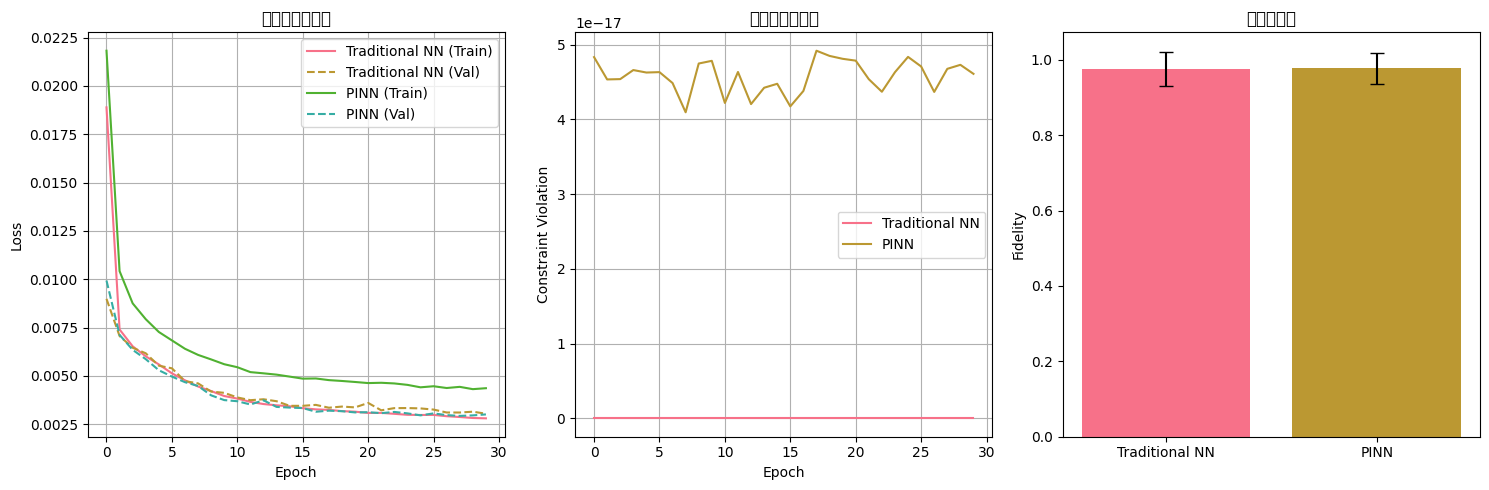

In [29]:
# 结果汇总
import pandas as pd

comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'Model': name,
        'fidelity_mean': result['fidelity_mean'],
        'fidelity_std': result['fidelity_std'],
        'mse_mean': result['mse_mean'],
        'mse_std': result['mse_std'],
        'cv_mean': result['cv_mean'],
        'cv_std': result['cv_std']
    })

comparison_df = pd.DataFrame(comparison_data)
print("模型性能汇总:")
print(comparison_df)

# 可视化训练过程
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for name, result in results.items():
    axes[0].plot(result['train_losses'], label=f'{name} (Train)')
    axes[0].plot(result['val_losses'], '--', label=f'{name} (Val)')
    axes[1].plot(result['constraint_violations'], label=name)
    axes[2].bar(name, result['fidelity_mean'], yerr=result['fidelity_std'], capsize=5)

axes[0].set_title('训练和验证损失')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('物理约束违反度')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Constraint Violation')
axes[1].legend()
axes[1].grid(True)

axes[2].set_title('平均保真度')
axes[2].set_ylabel('Fidelity')

plt.tight_layout()
plt.show()

## 10. 3量子比特系统扩展实验

In [30]:
# 生成3量子比特数据集
n_qubits_3 = 3
train_dataset_3 = MultiQubitDataset(n_qubits=n_qubits_3, n_samples=6000, n_measurements=128, noise_level=0.03)
test_dataset_3 = MultiQubitDataset(n_qubits=n_qubits_3, n_samples=1500, n_measurements=128, noise_level=0.03)

# 创建数据加载器
train_loader_3 = DataLoader(train_dataset_3, batch_size=32, shuffle=True)
test_loader_3 = DataLoader(test_dataset_3, batch_size=32, shuffle=False)

print(f"3量子比特系统:")
print(f"训练集大小: {len(train_dataset_3)}")
print(f"测试集大小: {len(test_dataset_3)}")
print(f"测量数据维度: {train_dataset_3.measurements.shape[1]}")
print(f"目标参数维度: {train_dataset_3.target_params.shape[1]}")

# 定义3量子比特模型
input_dim_3 = train_dataset_3.measurements.shape[1]
output_dim_3 = train_dataset_3.target_params.shape[1]

models_3 = {
    'Traditional NN': nn.Sequential(
        nn.Linear(input_dim_3, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_dim_3)
    ),
    'PINN': MultiQubitPINN(n_qubits_3, input_dim_3, [256, 128], output_dim_3)
}

# 训练3量子比特模型
results_3 = {}
trained_models_3 = {}

for name, model in models_3.items():
    print(f"\n{'='*50}")
    print(f"训练 3量子比特 {name}")
    print(f"{'='*50}")
    
    trainer = MultiQubitTrainer(model, device)
    history = trainer.train(train_loader_3, test_loader_3, epochs=20)
    
    results_3[name] = history
    trained_models_3[name] = model
    
    eval_results = evaluate_model(model, test_loader_3, device)
    results_3[name].update(eval_results)
    
    print(f"\n{name} 最终评估结果:")
    for key, value in eval_results.items():
        if value is not None:
            print(f"  {key}: {value:.6f}")

print("\n3量子比特系统训练完成！")

生成 6000 个 3 量子比特量子态的数据集...


100%|██████████| 6000/6000 [00:13<00:00, 454.71it/s]


数据集生成完成！
  测量数据形状: (6000, 64)
  真实状态形状: (6000, 8, 8)
  目标参数形状: (6000, 64)
生成 1500 个 3 量子比特量子态的数据集...


100%|██████████| 1500/1500 [00:03<00:00, 467.53it/s]


数据集生成完成！
  测量数据形状: (1500, 64)
  真实状态形状: (1500, 8, 8)
  目标参数形状: (1500, 64)
3量子比特系统:
训练集大小: 6000
测试集大小: 1500
测量数据维度: 64
目标参数维度: 64

训练 3量子比特 Traditional NN
开始训练 Sequential...


 55%|█████▌    | 11/20 [00:01<00:01,  6.14it/s]

Epoch 10/20, Train Loss: 0.0023, Val Loss: 0.0024, CV: 0.000000


100%|██████████| 20/20 [00:03<00:00,  6.06it/s]

Epoch 20/20, Train Loss: 0.0019, Val Loss: 0.0022, CV: 0.000000


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 4)

## 11. 可扩展性分析

In [ ]:
# 比较不同量子比特数下的性能
scalability_data = []

# 2量子比特结果
for name, result in results.items():
    scalability_data.append({
        'Qubits': 2,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

# 3量子比特结果
for name, result in results_3.items():
    scalability_data.append({
        'Qubits': 3,
        'Model': name,
        'Fidelity': result['fidelity_mean'],
        'Constraint_Violation': result['cv_mean']
    })

scalability_df = pd.DataFrame(scalability_data)
print("可扩展性分析:")
print(scalability_df)

# 可视化可扩展性
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name in ['Traditional NN', 'PINN']:
    data = scalability_df[scalability_df['Model'] == name]
    axes[0].plot(data['Qubits'], data['Fidelity'], marker='o', label=name)
    axes[1].plot(data['Qubits'], data['Constraint_Violation'], marker='o', label=name)

axes[0].set_title('保真度 vs 量子比特数')
axes[0].set_xlabel('量子比特数')
axes[0].set_ylabel('保真度')
axes[0].legend()
axes[0].grid(True)

axes[1].set_title('约束违反度 vs 量子比特数')
axes[1].set_xlabel('量子比特数')
axes[1].set_ylabel('约束违反度')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print("\n实验完成！")